In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.impute import KNNImputer
from numpy import arange
from sklearn.preprocessing import LabelBinarizer
from scipy.stats import normaltest, linregress
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import MinMaxScaler

In [2]:
fao_data = pd.read_csv("master_data_processed.csv")
del fao_data['Unnamed: 0']
#del fao_data['Superphosphates, other']
fao_data.columns

Index(['Year', 'Nutrient nitrogen N (total) - tonnes',
       'Nutrient phosphate P2O5 (total) - tonnes',
       'Nutrient potash K2O (total) - tonnes', 'Item', 'harvest_area (ha)',
       'Yield(tonnes/ha)', 'Fung & Bact – Benzimidazoles',
       'Fung & Bact – Diazines, morpholines', 'Fung & Bact – Dithiocarbamates',
       'Fung & Bact – Inorganics', 'Fung & Bact – Other',
       'Fung & Bact – Triazoles, diazoles', 'Herbicides – Amides',
       'Herbicides – Carbamates', 'Herbicides – Dinitroanilines',
       'Herbicides – Other', 'Herbicides – Phenoxy hormone products',
       'Herbicides – Triazines', 'Herbicides – Urea derivates',
       'Insecticides – Botanical products and biologicals',
       'Insecticides – Carbamates', 'Insecticides – Organo-phosphates',
       'Insecticides – Other', 'Insecticides – Pyrethroids', 'Mineral Oils',
       'Plant Growth Regulators', 'Rodenticides – Other',
       'Herbicides – Bipiridils', 'Herbicides – Sulfonyl ureas',
       'Rodenticides –

In [3]:
crops1 = ['Wheat', 'Barley', 'Maize', 'Sugar beet', 'Potatoes', 'Rye', 'Rape', 'Apples', 'Grapes', 'Cabbages']
mask = fao_data["Item"].str.contains("|".join(crops1))
df = fao_data[mask]
df.reset_index(drop=True, inplace=True)
df.columns

Index(['Year', 'Nutrient nitrogen N (total) - tonnes',
       'Nutrient phosphate P2O5 (total) - tonnes',
       'Nutrient potash K2O (total) - tonnes', 'Item', 'harvest_area (ha)',
       'Yield(tonnes/ha)', 'Fung & Bact – Benzimidazoles',
       'Fung & Bact – Diazines, morpholines', 'Fung & Bact – Dithiocarbamates',
       'Fung & Bact – Inorganics', 'Fung & Bact – Other',
       'Fung & Bact – Triazoles, diazoles', 'Herbicides – Amides',
       'Herbicides – Carbamates', 'Herbicides – Dinitroanilines',
       'Herbicides – Other', 'Herbicides – Phenoxy hormone products',
       'Herbicides – Triazines', 'Herbicides – Urea derivates',
       'Insecticides – Botanical products and biologicals',
       'Insecticides – Carbamates', 'Insecticides – Organo-phosphates',
       'Insecticides – Other', 'Insecticides – Pyrethroids', 'Mineral Oils',
       'Plant Growth Regulators', 'Rodenticides – Other',
       'Herbicides – Bipiridils', 'Herbicides – Sulfonyl ureas',
       'Rodenticides –

In [4]:
crop_names = df['Item'].unique()
crop_names

array(['Barley', 'Cabbages', 'Maize (corn)', 'Potatoes',
       'Rape or colza seed', 'Rye', 'Sugar beet', 'Wheat', 'Apples',
       'Grapes'], dtype=object)

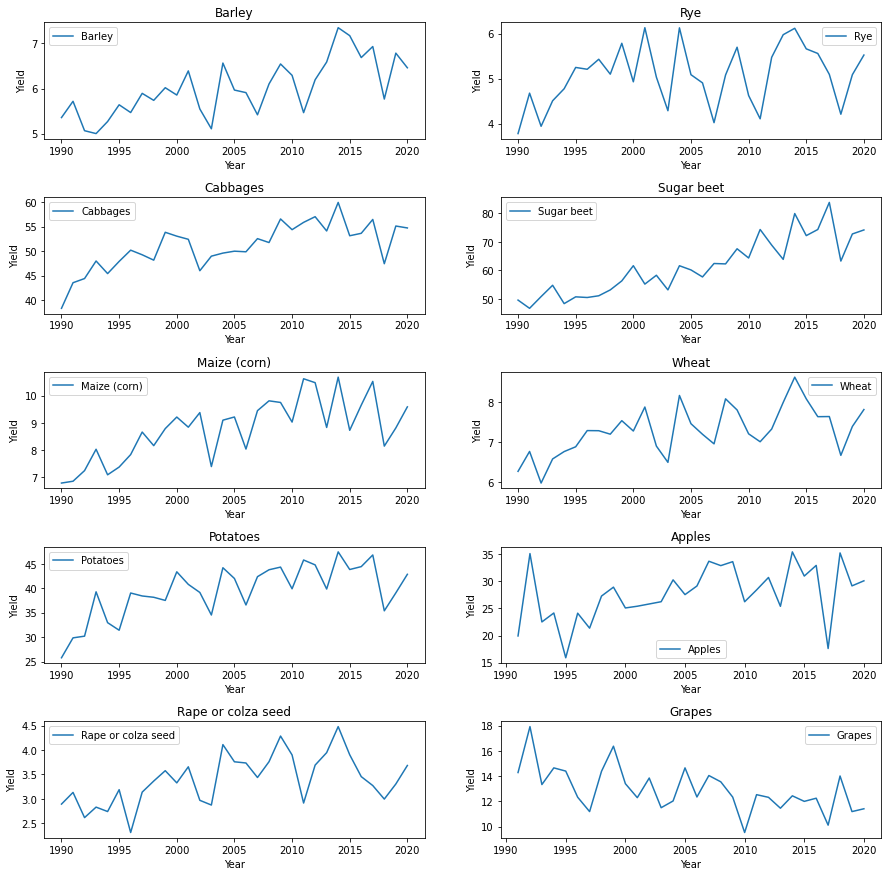

In [5]:
fig, axs = plt.subplots(nrows=5, ncols=2, figsize=(15, 15) )
count = 0
for crop in crop_names:
    crop_df = df[df["Item"] == crop]
    year_list = crop_df["Year"]
    yield_data = crop_df["Yield(tonnes/ha)"]
    
    # Determine the row and column indices of the subplot
    row_idx = count % 5
    col_idx = count // 5
    
    # Select the appropriate subplot
    ax = axs[row_idx, col_idx]
    
    # Plot the yield data for the current item on the subplot
    ax.plot(year_list, yield_data, label=crop)
    
    # Set the title and axis labels for the subplot
    ax.set_title(crop)
    ax.set_xlabel('Year')
    ax.set_ylabel('Yield')
    
    # Add a legend to the subplot
    ax.legend()
    
    # change axis
    count +=1

plt.subplots_adjust(wspace=0.2, hspace=0.5)
# Show the figure
plt.show()